# Loading the climate data
---
### The Origin.
World wide climate data was obtained from the US National Oceanic and Atmospheric Administration (NOAA) (see [here](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/)).

### The Format.
Daily measurements are made available for weather stations with latitude and longitude information of each station. To make use of the data in this project, each station is mapped to its country and an aggregate statistic is calculated for each country and each year.

### The Indicator.
In order to make the climate data compatible with the already implemented data (World Bank, UNHCR, etc.) yearly aggregate indicators need to be generated from the daily measurements of temperature, precipitation, etc. I believe that one promising way of looking at the data could be to focus on extreme events that occur during one year. But what is an extreme event? The average weather observed during one month should be relatively stable over the years and I decided to declare a month as extreme if its average value lies outside of a certain standard deviation window of the average over all past years.
Practically speaking I calculate for each year and each month the average temperature observed during that month and compare it to the past. If the average deviates from the experience it will be called extreme.

---

In the following I will look at the distribution of how much monthly average readings deviate from the expectation based on the past history. This will aid in determining a good metric for when to call an weather event extreme.

Let's load the climate data and have a brief look. We will restrict the weather data to the years from 1900 to 2014 and we will set the ```optimiseFactor``` flag to obtain the averagage and standart deviation calculation for each weather station.

In [1]:
%pylab inline
import sys
sys.path.insert(0,"../lib/")
from scipy.stats import norm

from climateData import WeatherData

Populating the interactive namespace from numpy and matplotlib


In [2]:
weatherData = WeatherData(years=[1900,2014], optimiseFactor=True)

Generating the data from the original data..
Finished loading the data: 0:48:19


Now we have the weatherData object with its data variable containing four extra columns, i.e. ```Month```, ```_LastYearsAvg```, ```_LastYearsStd```, and ```_ThisYear```. The columns ```_LastYearsAvg``` and ```_LastYearsStd``` contain the average and standard deviation of all previous years of month ```Month``` respectively. Columns ```_ThisYear``` contains the average of the current month of the year.

In [3]:
weatherData.data.head()

,Station ID,level_1,Country,Element,Month,Value,Year,_LastYearsAvg,_LastYearsStd,_ThisYear
0,AE000041196,0,ARE,PRCP,1,0,1984,4.645161,6.569250,3.333333
1,AE000041196,1,ARE,PRCP,1,0,2013,17.960014,32.053524,0.214286
2,AE000041196,2,ARE,PRCP,1,0,2014,16.974140,31.414521,3.375000
3,AE000041196,3,ARE,PRCP,1,0,1997,4.317204,5.717425,0.000000
4,AE000041196,4,ARE,PRCP,1,0,1998,3.453763,5.397526,0.000000


First let's remove the early years in which we are not interested in. Note also that there might be months containing -9999. This can happen if they constitute the first months in which the measurement was available (and no last years are available). In addition create a new column containing the difference of the measured averages, thus making them better comparable.

In [4]:
data = weatherData.data[ weatherData.data["Year"] >= 1980 ]
data = data[ np.isclose(data["_LastYearsStd"], -9999.0) == False ]
data["avg_diff"] = data["_LastYearsAvg"] - data["_ThisYear"]

In order get a feel for a good classification for extreme climate events we can look at the distribution of the difference between the average values and the distribution of the standard deviations. I will take the maximum temperature reading as an example.

In [5]:
data_tmax = data[ data["Element"] == "TMAX" ]
hist_avg, bin_edges_avg = np.histogram( np.abs(np.abs(np.asarray( data_tmax["avg_diff"] ))), bins=100 )
hist_std, bin_edges_std = np.histogram( np.abs(np.asarray( data_tmax["_LastYearsStd"] )), bins=100 )

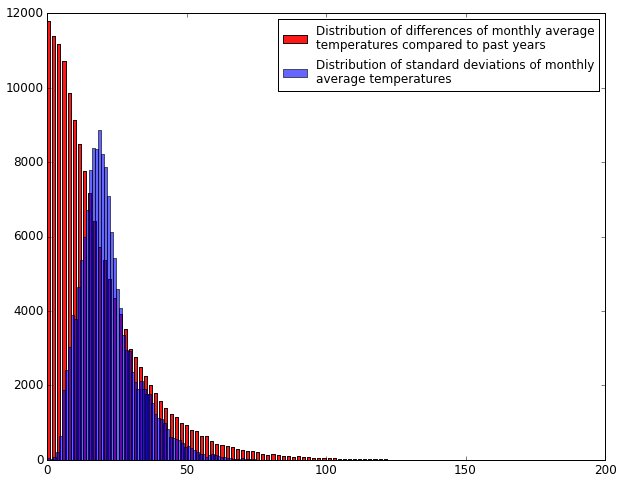

In [6]:
fig = plt.figure(figsize=(10, 8), dpi=200)
ax  = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=12)

label_avg = "Distribution of differences of monthly average\ntemperatures compared to past years"
label_std = "Distribution of standard deviations of monthly\naverage temperatures"

ax.bar(bin_edges_avg[:-1], hist_avg, width = 1.1, facecolor="red",  alpha=0.9, label=label_avg);
ax.bar(bin_edges_std[:-1], hist_std, width = 1.1, facecolor="blue", alpha=0.6, label=label_std, zorder=5);

plt.legend();

This already gives us an indication that there are events that are extreme in the sense that they deviate by more than 1-2 standard deviations from the average of past years. However this still does not give us a robust and good indicator of when to call a climate event extreme.

A relative measure will be much more helpful in determining a good cutoff value. So instead of looking at the two distributions we can look at how much the average of the current year deviates from the past years in units of the standard deviation. Values that deviate by more than one standard deviation will then have values above one (and vice versa).

In [7]:
data["avg_diff_fold"] = np.abs(data["avg_diff"]) / data["_LastYearsStd"]
data_tmax = data[ data["Element"] == "TMAX" ]

For plotting we will remove the few events that deviate extremely and would render the plotting impossible

In [8]:
tmpData = np.abs(np.asarray( data_tmax["avg_diff_fold"] ))
tmpData = tmpData[ tmpData < np.percentile(tmpData, 99.9) ]
hist_avg_fold, bin_edges_avg_fold = np.histogram(tmpData, bins=100, density=True)

Here I will take prior knowlede (I looked already at the plot and went back one step) and assume that the distribution will look like a normal distribution. To visually emphasize this point we can fit the distribution and add the fit to the plot.

In [9]:
mu, std = norm.fit(np.concatenate((-tmpData,tmpData), axis=1))
x = np.linspace(0, 5, 100)
p = norm.pdf(x, mu, std)
print("Fitted a normal distribution at %.1f with standard deviation %.2f" %(mu, std))

Fitted a normal distribution at 0.0 with standard deviation 1.09


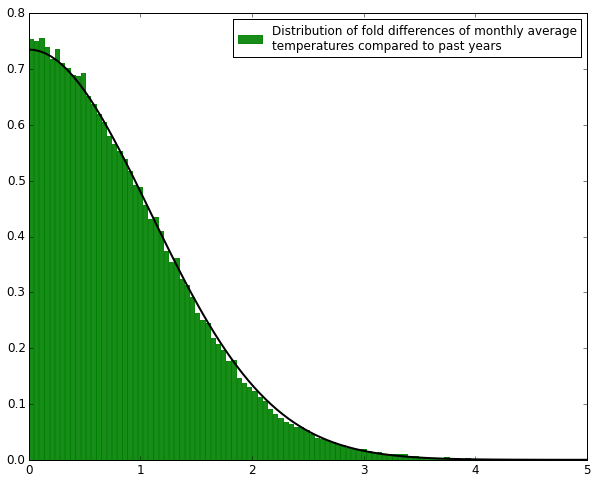

In [10]:
fig = plt.figure(figsize=(10, 8), dpi=200)
ax  = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=12)

label_avg_fold = "Distribution of fold differences of monthly average\ntemperatures compared to past years"

ax.bar(bin_edges_avg_fold[:-1], hist_avg_fold, width = 0.04, facecolor="green", edgecolor="green", alpha=0.9, label=label_avg_fold);
ax.plot(x, 2*p, 'k', linewidth=2)

plt.legend();

From the plot we can see that there is no obvious cutoff point that we could choose so we will have to use common sense. I would argue that a good measure would be to declare the 25% highest values as extreme. This will give us a cuttoff point of:

In [11]:
cutoff = np.percentile(tmpData, 85)
print("The cutoff point is set to %.2f" %cutoff)

The cutoff point is set to 1.54


What the plot above is not telling us is how the individual bins of the histogram are populated in time. By that I mean that each event in the histogram is linked to the year in which the measurement was taken. We can now ask the question if events that deviate far from the all time averages are more likely to have occured in the recent past or if they are equally distributed.

Two answer that question let us look at the average of the years for each bin.

In [12]:
bin_years = list()
for i in range(1,len(bin_edges_avg_fold)):
    start, end = bin_edges_avg_fold[i-1], bin_edges_avg_fold[i]
    tmp = data_tmax[ data_tmax["avg_diff_fold"] > start ]
    tmp = tmp[ tmp["avg_diff_fold"] < end ]
    bin_years.append(tmp["Year"])

avg_time   = [ np.average(item) for item in bin_years ]
avg_time_X = [ i*0.05 for i in range(1,len(avg_time)+1) ] # make the plot go from 0 to 5 and not from 0 to 100

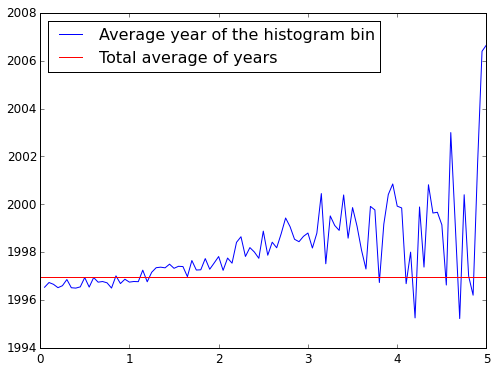

In [13]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax  = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.plot(avg_time_X, avg_time, label="Average year of the histogram bin");
ax.axhline(np.average(data_tmax["Year"]), 0, 100, color="red", label="Total average of years");
plt.legend(loc=2, fontsize=16);

This is a very interesting plot! For each bin of the histogram shown above we calculated the average year of all events falling into this bin. If we would assume that the weather is stable over the years we would expect that each bin should have the same average. In that case we would expect that the blue line would fluctuate around the red line. What we can see however, looks like an effect of climate change. What this plot tells us is that more extreme events became more likely in the recent years! To most of us this will not come as a surprise but it is always reassuring to find known events in the data after doing a lot of processing to it.